In [1]:
from tsai.all import *
import sklearn.metrics as skm

from IPython.display import clear_output
computer_setup()

os              : Windows-10-10.0.22621-SP0
python          : 3.8.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.9.1+cu111
device          : 1 gpu (['NVIDIA GeForce RTX 2070 SUPER'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.92 GB
GPU memory      : [8.0] GB


### Resteaze Data

In [2]:
# Read the data
data = pd.read_csv('final_processed.csv', index_col=0)

data.tail()

,level_0,index,unixTimes,accelerometerX,accelerometerY,accelerometerZ,gyroscopeX,gyroscopeY,gyroscopeZ,ledGreen,...,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
9181496,18362992,1310204.5,1.648124e+12,-2192.50,159.75,3402.00,14.25,-199.25,61.50,-38.178333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9181497,18362994,1310206.5,1.648124e+12,-2194.00,163.75,3395.50,19.75,-201.00,57.75,-29.258338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9181498,18362996,1310208.5,1.648124e+12,-2193.75,167.00,3394.75,17.00,-222.25,58.00,-18.186857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9181499,18362998,1310210.5,1.648124e+12,-2192.00,161.50,3398.00,22.75,-246.75,54.00,-7.657366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9181500,18363000,1310212.5,1.648124e+12,-2187.25,163.00,3402.00,25.00,-237.25,58.50,0.566843,...,134.366369,222.843576,0.888889,0.777778,80.0,157.351188,119.835278,59238.572803,1.313062,0.20436


In [3]:
df = data.copy()

df = df[df.sleep_state != -1]

# Binary Classification
df["sleep_state"] = np.where(df["sleep_state"] == 0, 0, 1)

# fill NaN values
df = df.fillna(method='bfill', limit=1500).dropna()

# # set column time as datetime index
# df['time'] = pd.to_datetime(df['time'])
# df = df.set_index('time', drop=True)

df = df[['ledGreen', 'bpm', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'sleep_state']]


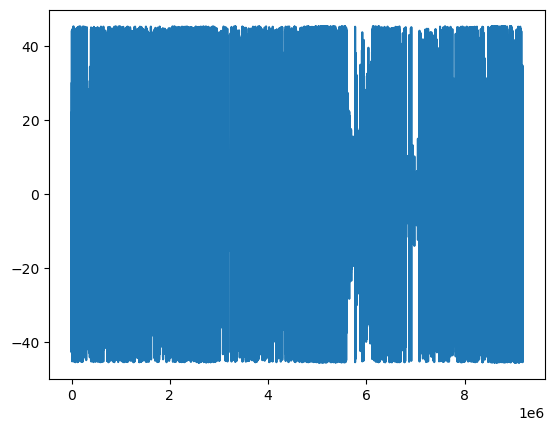

In [6]:
# df = ((df + df.shift(-1)) / 2)[::2]

# remove extreme values from the signal (outliers)


def remove_extreme_values(signal, threshold):
    # Compute the absolute difference between the signal and its mean
    absolute_difference = np.abs(signal - np.mean(signal))
    # Compute the median of the absolute difference
    median_absolute_difference = np.median(absolute_difference)
    # Compute the median absolute deviation
    median_absolute_deviation = 1.4826 * median_absolute_difference
    # Compute the z-score
    z_score = 0.6745 * (absolute_difference / median_absolute_deviation)
    # Remove the extreme values
    signal = signal[z_score < threshold]
    return signal


# Example usage
filtered_ppg = remove_extreme_values(df['ledGreen'], threshold=3.0)
filtered_bpm = remove_extreme_values(df['bpm'], threshold=3.0)
filtered_rmssd = remove_extreme_values(df['rmssd'], threshold=3.0)
filtered_pnn20 = remove_extreme_values(df['pnn20'], threshold=3.0)
filtered_pnn50 = remove_extreme_values(df['pnn50'], threshold=3.0)
filtered_hr_mad = remove_extreme_values(df['hr_mad'], threshold=3.0)
filtered_sd1 = remove_extreme_values(df['sd1'], threshold=3.0)
filtered_sd2 = remove_extreme_values(df['sd2'], threshold=3.0)
filtered_accelerometerX = remove_extreme_values(df['accelerometerX'], threshold=3.0)
filtered_accelerometerY = remove_extreme_values(df['accelerometerY'], threshold=3.0)
filtered_accelerometerZ = remove_extreme_values(df['accelerometerZ'], threshold=3.0)
filtered_gyroscopeX = remove_extreme_values(df['gyroscopeX'], threshold=3.0)
filtered_gyroscopeY = remove_extreme_values(df['gyroscopeY'], threshold=3.0)
filtered_gyroscopeZ = remove_extreme_values(df['gyroscopeZ'], threshold=3.0)


df['ledGreen'] = filtered_ppg
df['bpm'] = filtered_bpm
df['rmssd'] = filtered_rmssd
df['pnn20'] = filtered_pnn20
df['pnn50'] = filtered_pnn50
df['hr_mad'] = filtered_hr_mad
df['sd1'] = filtered_sd1
df['sd2'] = filtered_sd2
df['accelerometerX'] = filtered_accelerometerX
df['accelerometerY'] = filtered_accelerometerY
df['accelerometerZ'] = filtered_accelerometerZ
df['gyroscopeX'] = filtered_gyroscopeX
df['gyroscopeY'] = filtered_gyroscopeY
df['gyroscopeZ'] = filtered_gyroscopeZ

df = df.dropna()

plt.plot(filtered_ppg)

In [7]:
# Non null values in the dataset
df.isnull().sum()

ledGreen          0
bpm               0
rmssd             0
pnn20             0
pnn50             0
hr_mad            0
sd1               0
sd2               0
accelerometerX    0
accelerometerY    0
accelerometerZ    0
gyroscopeX        0
gyroscopeY        0
gyroscopeZ        0
sleep_state       0
dtype: int64

In [8]:
class_map = {
    0: 'WK',  # wake
    1: 'SL',  # sleep
}
class_map

{0: 'WK', 1: 'SL'}

<AxesSubplot:>

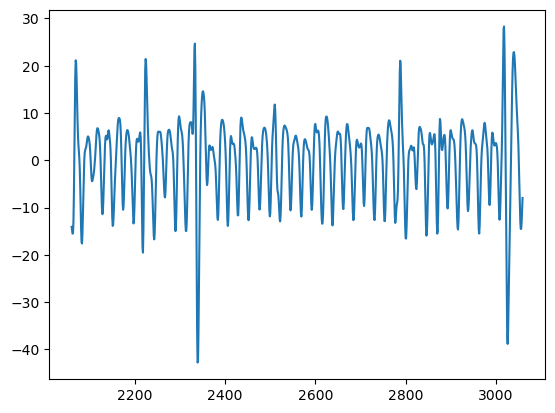

In [9]:
df['ledGreen'][2000:3000].plot()

# Filters and transforms

## TSData preparation

## Data from 3d array

In [12]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder


scaler = StandardScaler()
le = LabelEncoder()

temp_df = df[['ledGreen', 'bpm', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'sleep_state']]
X = scaler.fit_transform(temp_df.drop('sleep_state', axis=1))
y = le.fit_transform(temp_df['sleep_state'])

# selecting sequences range
X = X[0:(len(X) - len(X) % 1500)]
y = y[0:(len(y) - len(y) % 1500)]

# reshape the data to tsai format
X = X.reshape(-1, 1500, 14)
X = X.transpose(0, 2, 1)
y = y.reshape(-1, 1500)
y = (y.sum(axis=1) // 1500).reshape(-1, 1).flatten()

print(X.shape, y.shape)

pd.DataFrame(X[0])

(4130, 14, 1500) (4130,)


,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,3.511098,-3.441734,2.510957,1.654117,-0.513232,-2.508292,-3.363246,-2.677016,-2.020238,-1.440856,...,-0.025599,-0.259027,-0.459134,-0.610161,-0.694336,-0.702821,-0.642530,-0.528596,-0.374784,-0.197798
1,-0.328731,-0.328731,-0.328731,-0.328731,-0.328731,-0.328731,-0.328731,-0.328731,-0.328731,-0.328731,...,0.108858,0.108858,0.108858,0.108858,0.108858,0.108858,0.108858,0.108858,0.108858,0.108858
2,0.395687,0.395687,0.395687,0.395687,0.395687,0.395687,0.395687,0.395687,0.395687,0.395687,...,1.730537,1.730537,1.730537,1.730537,1.730537,1.730537,1.730537,1.730537,1.730537,1.730537
3,0.469685,0.469685,0.469685,0.469685,0.469685,0.469685,0.469685,0.469685,0.469685,0.469685,...,1.411216,1.411216,1.411216,1.411216,1.411216,1.411216,1.411216,1.411216,1.411216,1.411216
4,1.162858,1.162858,1.162858,1.162858,1.162858,1.162858,1.162858,1.162858,1.162858,1.162858,...,1.299468,1.299468,1.299468,1.299468,1.299468,1.299468,1.299468,1.299468,1.299468,1.299468
5,0.554867,0.554867,0.554867,0.554867,0.554867,0.554867,0.554867,0.554867,0.554867,0.554867,...,0.554867,0.554867,0.554867,0.554867,0.554867,0.554867,0.554867,0.554867,0.554867,0.554867
6,0.516931,0.516931,0.516931,0.516931,0.516931,0.516931,0.516931,0.516931,0.516931,0.516931,...,1.877658,1.877658,1.877658,1.877658,1.877658,1.877658,1.877658,1.877658,1.877658,1.877658
7,1.473752,1.473752,1.473752,1.473752,1.473752,1.473752,1.473752,1.473752,1.473752,1.473752,...,0.919860,0.919860,0.919860,0.919860,0.919860,0.919860,0.919860,0.919860,0.919860,0.919860
8,-0.870245,-0.878063,-0.871783,-0.877935,-0.876525,-0.876012,-0.887290,-0.874603,-0.870886,-0.880113,...,-0.877550,-0.873193,-0.878832,-0.882548,-0.881651,-0.879601,-0.869861,-0.877550,-0.880754,-0.880498
9,0.553438,0.598086,0.581055,0.584738,0.591182,0.575072,0.589341,0.582897,0.552517,0.552057,...,0.573691,0.575532,0.557120,0.543772,0.546994,0.585658,0.566786,0.549295,0.557580,0.566326


In [13]:
# sht = len(X) // 1500
# print("Shape: ", sht)

# X = X.T.reshape(sht, 8, 1500)
# y = y.T.reshape(sht, 1500)
# y = (y.sum(axis=1) // 1500).reshape(-1, 1).flatten()

# X.shape, y.shape

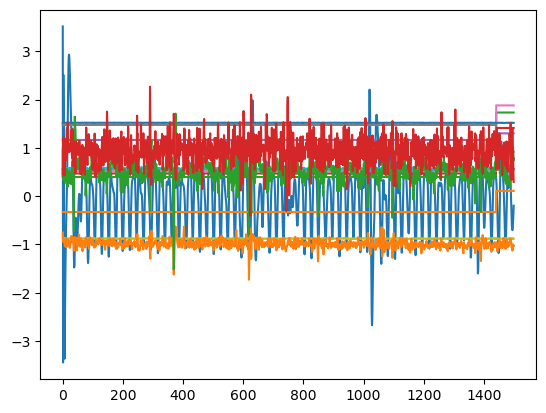

In [15]:
# plot the first 2 sequences
plt.plot(X[0].T)

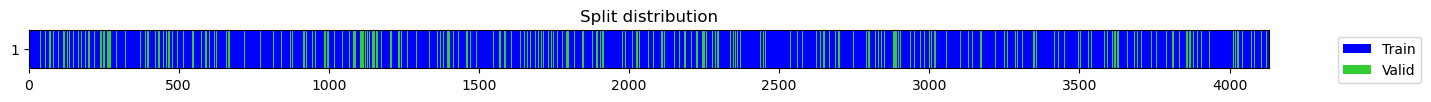

((#3304) [3188,2043,3324,1267,609,192,2607,1692,829,3010...],
 (#826) [2866,3659,2294,977,1524,1415,664,2613,3478,3908...])

In [16]:
splits = get_splits(y,
                    valid_size=.2,
                    stratify=True,
                    random_state=1223,
                    shuffle=True)
splits

In [17]:
labeler = ReLabeler(class_map)
new_y = labeler(y) # map to more descriptive labels

X.shape, new_y.shape, splits, new_y

((4130, 14, 1500),
 (4130,),
 ((#3304) [3188,2043,3324,1267,609,192,2607,1692,829,3010...],
  (#826) [2866,3659,2294,977,1524,1415,664,2613,3478,3908...]),
 array(['WK', 'WK', 'WK', ..., 'SL', 'SL', 'SL'], dtype='<U2'))

In [18]:
label_counts = collections.Counter(new_y)
print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

Counts by label: {'WK': 1346, 'SL': 2784}
Naive Accuracy: 67.41%


In [19]:
tfms = [None, [TSClassification()]]  # TSClassification == Categorize
batch_tfms = TSStandardize()

## Dataloaders

In [20]:
dls = get_ts_dls(X, new_y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.dataset

(#3304) [(TSTensor(vars:14, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:14, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:14, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:14, len:1500, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:14, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:14, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:14, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:14, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:14, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:14, len:1500, device=cpu, dtype=torch.float32), TensorCategory(1))] ...]

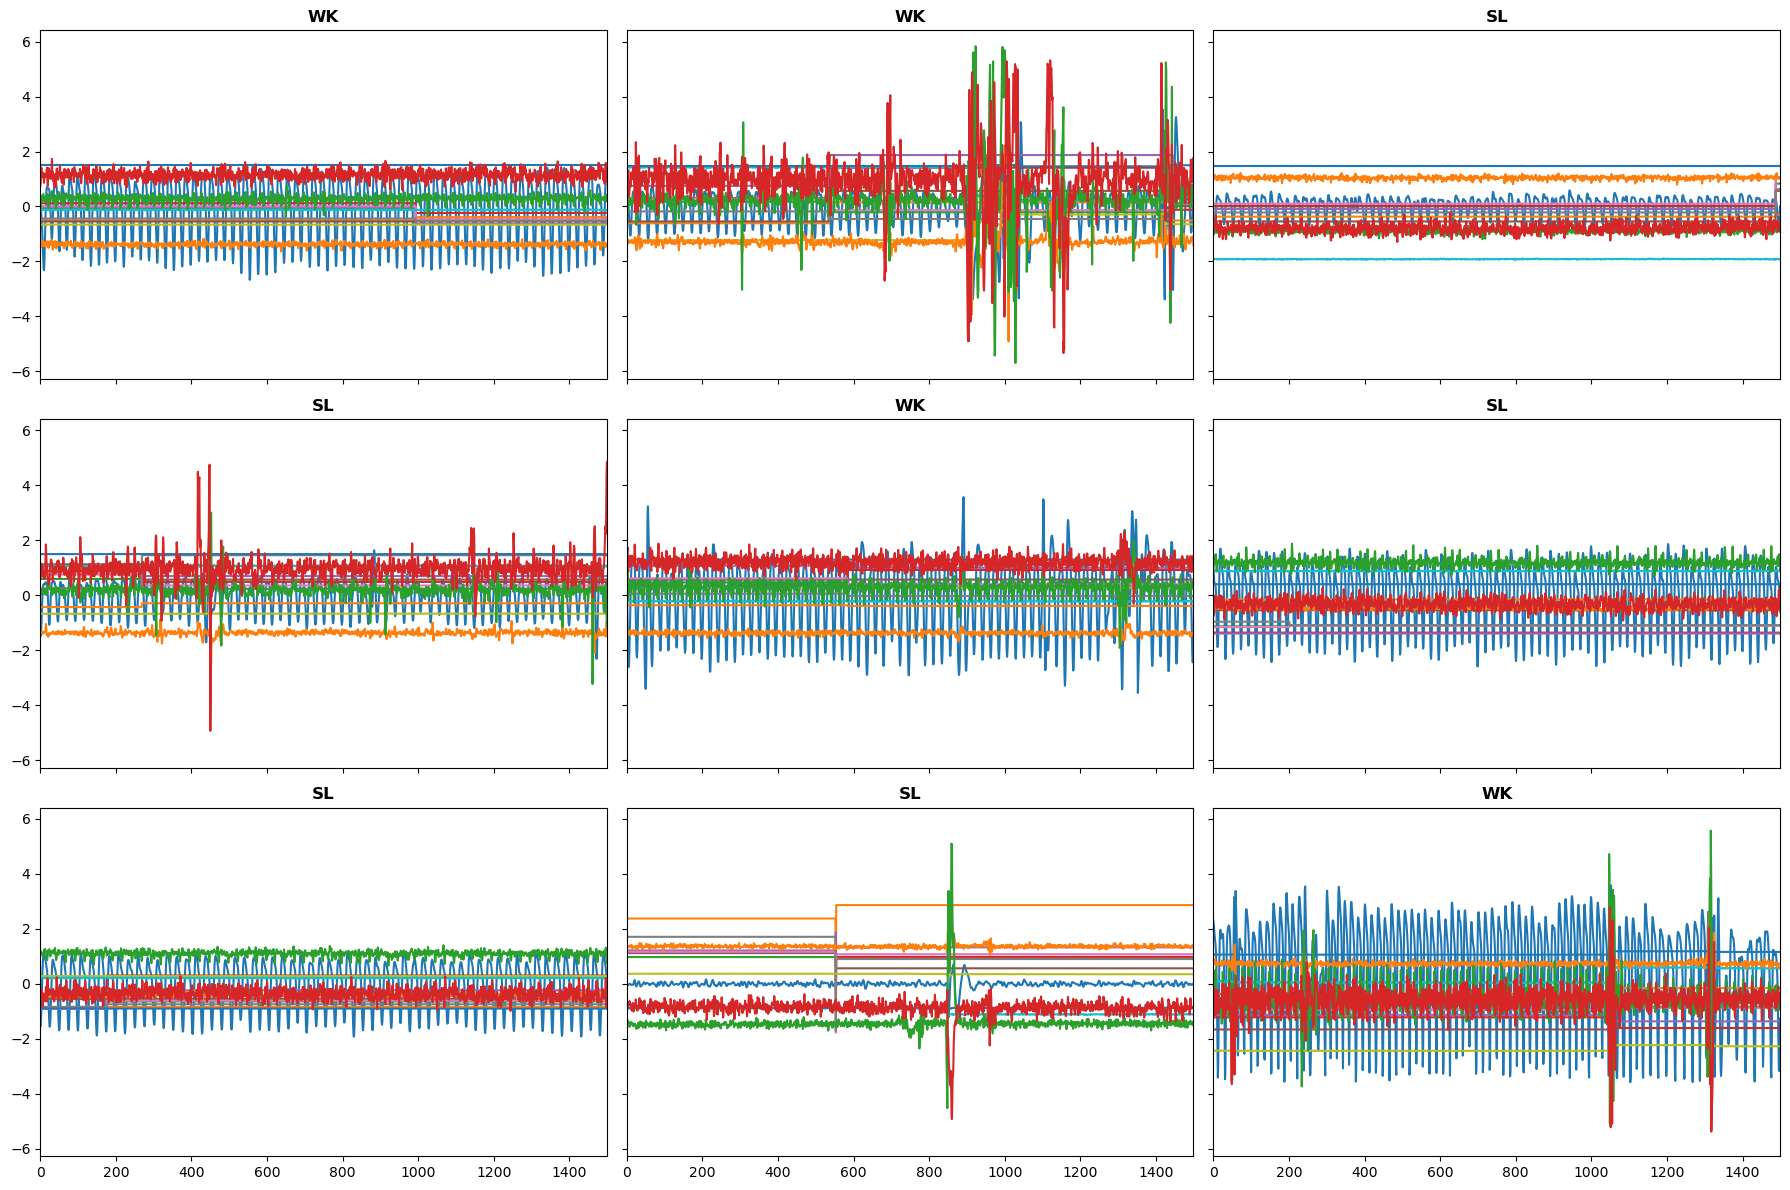

In [21]:
dls.show_batch(sharey=True)

## Build learner

In [22]:
archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}),
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}),
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]


# for i, (arch, k) in enumerate(archs):
#     print(f'arch: {arch.__name__}')

# results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
# for i, (arch, k) in enumerate(archs):
#     model = build_ts_model(arch, dls=dls, **k)
#     print(model.__class__.__name__)
#     learn = ts_learner(dls, model,  metrics=[accuracy, Precision(), Recall(), F1Score()])
#     start = time.time()
#     learn.fit_one_cycle(30, 1e-3)
#     elapsed = time.time() - start
#     vals = learn.recorder.values[-1]
#     results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
#     results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
#     clear_output()
#     display(results)

In [43]:
metrics = [accuracy, Precision(), Recall(), F1Score()]

model = build_ts_model(InceptionTimePlus, dls=dls)
# model = build_ts_model(InceptionTimePlus, dls=dls)

learn = ts_learner(dls, model, metrics=metrics, cbs=ShowGraph())

In [44]:
# learn = Learner(dls, model, metrics=accuracy)

## LR find

SuggestedLRs(valley=0.0020892962347716093)

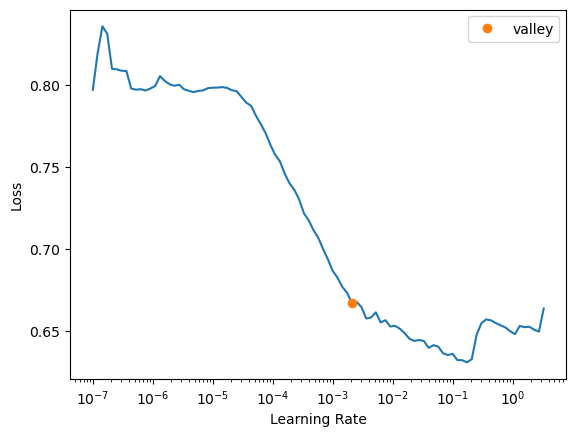

In [45]:
# learn.load('stage0')
learn.lr_find()

## Learner feature importance

X.shape: (3304, 14, 1500)
y.shape: (3304,)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 0.396186


  0 feature: var_0                accuracy: 0.389225


  1 feature: var_1                accuracy: 0.359564


  2 feature: var_2                accuracy: 0.378935


  3 feature: var_3                accuracy: 0.381961


  4 feature: var_4                accuracy: 0.373184


  5 feature: var_5                accuracy: 0.393462


  6 feature: var_6                accuracy: 0.430085


  7 feature: var_7                accuracy: 0.384080


  8 feature: var_8                accuracy: 0.385291


  9 feature: var_9                accuracy: 0.416465


 10 feature: var_10               accuracy: 0.369249


 11 feature: var_11               accuracy: 0.393462


 12 feature: var_12               accuracy: 0.365315


 13 feature: var_13               accuracy: 0.361683



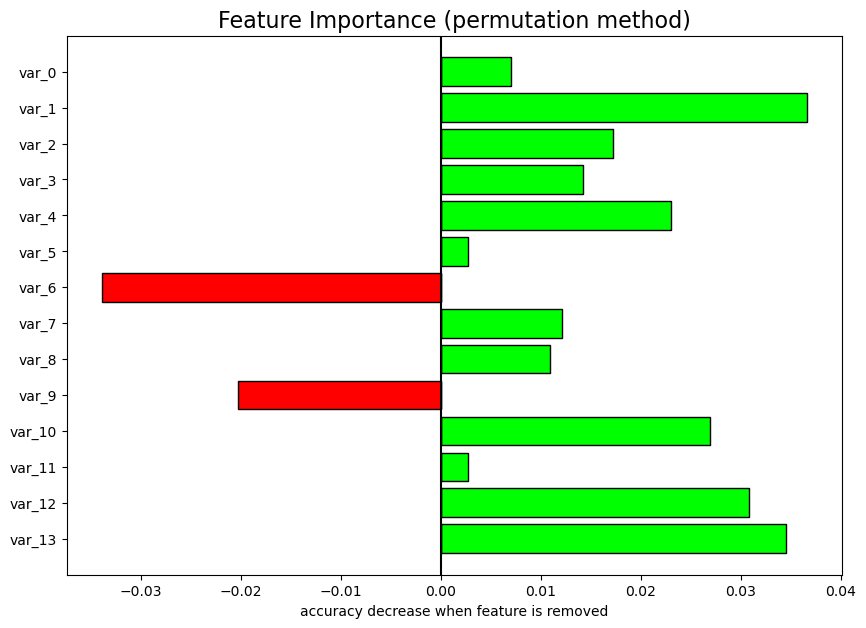

,Feature,accuracy,accuracy_change
0,var_1,0.359564,0.036622
1,var_13,0.361683,0.034504
2,var_12,0.365315,0.030872
3,var_10,0.369249,0.026937
4,var_4,0.373184,0.023002
5,var_2,0.378935,0.017252
6,var_3,0.381961,0.014225
7,var_7,0.384080,0.012107
8,var_8,0.385291,0.010896
9,var_0,0.389225,0.006961


In [46]:
learn.feature_importance()

In [47]:
# learn.step_importance()

Before temperature - NLL: 0.723, ECE: 0.132
Calibrating the model...
...model calibrated
Optimal temperature: 480.010
After temperature  - NLL: 0.693, ECE: 0.086



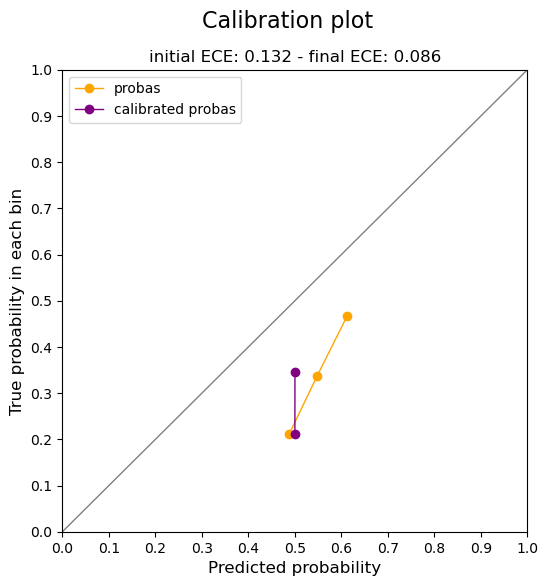

In [48]:
learn.calibrate_model()

# Fit model

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.565621,0.486911,0.774818,0.702439,0.535316,0.607595,00:10
1,0.476157,0.413594,0.814770,0.739669,0.665428,0.700587,00:09
2,0.413256,0.386274,0.835351,0.787879,0.676580,0.728000,00:09
3,0.381252,0.389849,0.843826,0.761194,0.758364,0.759777,00:10
4,0.360575,0.420400,0.812349,0.747826,0.639405,0.689379,00:09
5,0.350248,0.349550,0.857143,0.868293,0.661710,0.751055,00:09
6,0.342520,0.393927,0.832930,0.763052,0.706320,0.733591,00:09
7,0.345467,0.414050,0.828087,0.779736,0.657993,0.713710,00:09
8,0.343287,0.372165,0.835351,0.769231,0.706320,0.736434,00:09
9,0.336568,0.388995,0.831719,0.857143,0.579926,0.691796,00:09


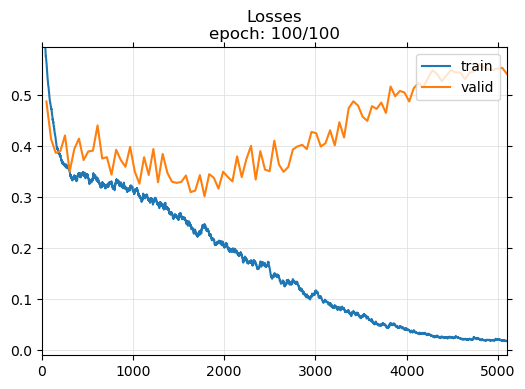

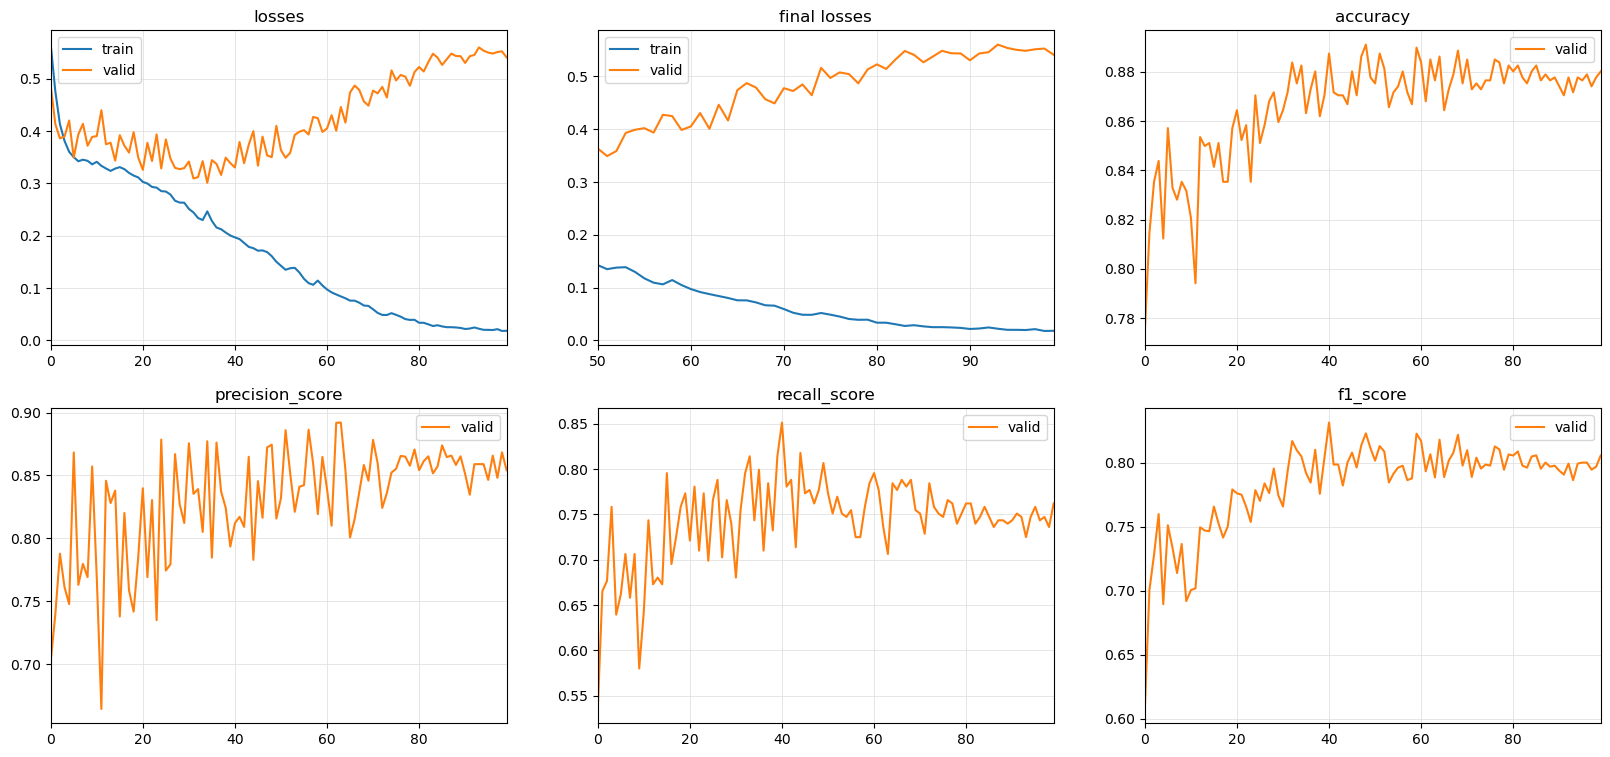

In [49]:
learn.fit_one_cycle(100, lr_max=1e-3)

In [50]:
# learn.fit_flat_cos(10, 0.025)

## Transformers 

In [51]:
# model = TST(dls.vars, dls.c, dls.len, dropout=.3)
# learn = Learner(dls,
#                 model,
#                 loss_func=LabelSmoothingCrossEntropyFlat(),
#                 metrics=[RocAucBinary(), accuracy],
#                 cbs=ShowGraphCallback2())
# start = time.time()
# learn.fit_one_cycle(25, lr_max=1e-4)
# print('\nElapsed time:', time.time() - start)
# learn.plot_metrics()
# beep()

##### Save model

In [52]:
learn.save('all_features')

Path('models/all_features.pth')

In [53]:
learn.save_all(path='export_all',
               dls_fname='dls',
               model_fname='model',
               learner_fname='learner')

## Inferece


In [54]:
# learn = load_learner_all(path='export_rmmsd',
#                          dls_fname='dls',
#                          model_fname='model',
#                          learner_fname='learner')

dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:128, vars:14, len:1500, device=cuda:0, dtype=torch.float32),
 TensorCategory([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
         0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [55]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl,
                                                           with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[7.2977e-01, 2.7023e-01],
         [9.4592e-01, 5.4078e-02],
         [9.9832e-01, 1.6844e-03],
         ...,
         [9.9905e-01, 9.5251e-04],
         [9.9797e-01, 2.0297e-03],
         [9.9965e-01, 3.4787e-04]]),
 tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
         0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
         0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 

In [56]:
(valid_targets == valid_preds).float().mean()

tensor(0.8801)

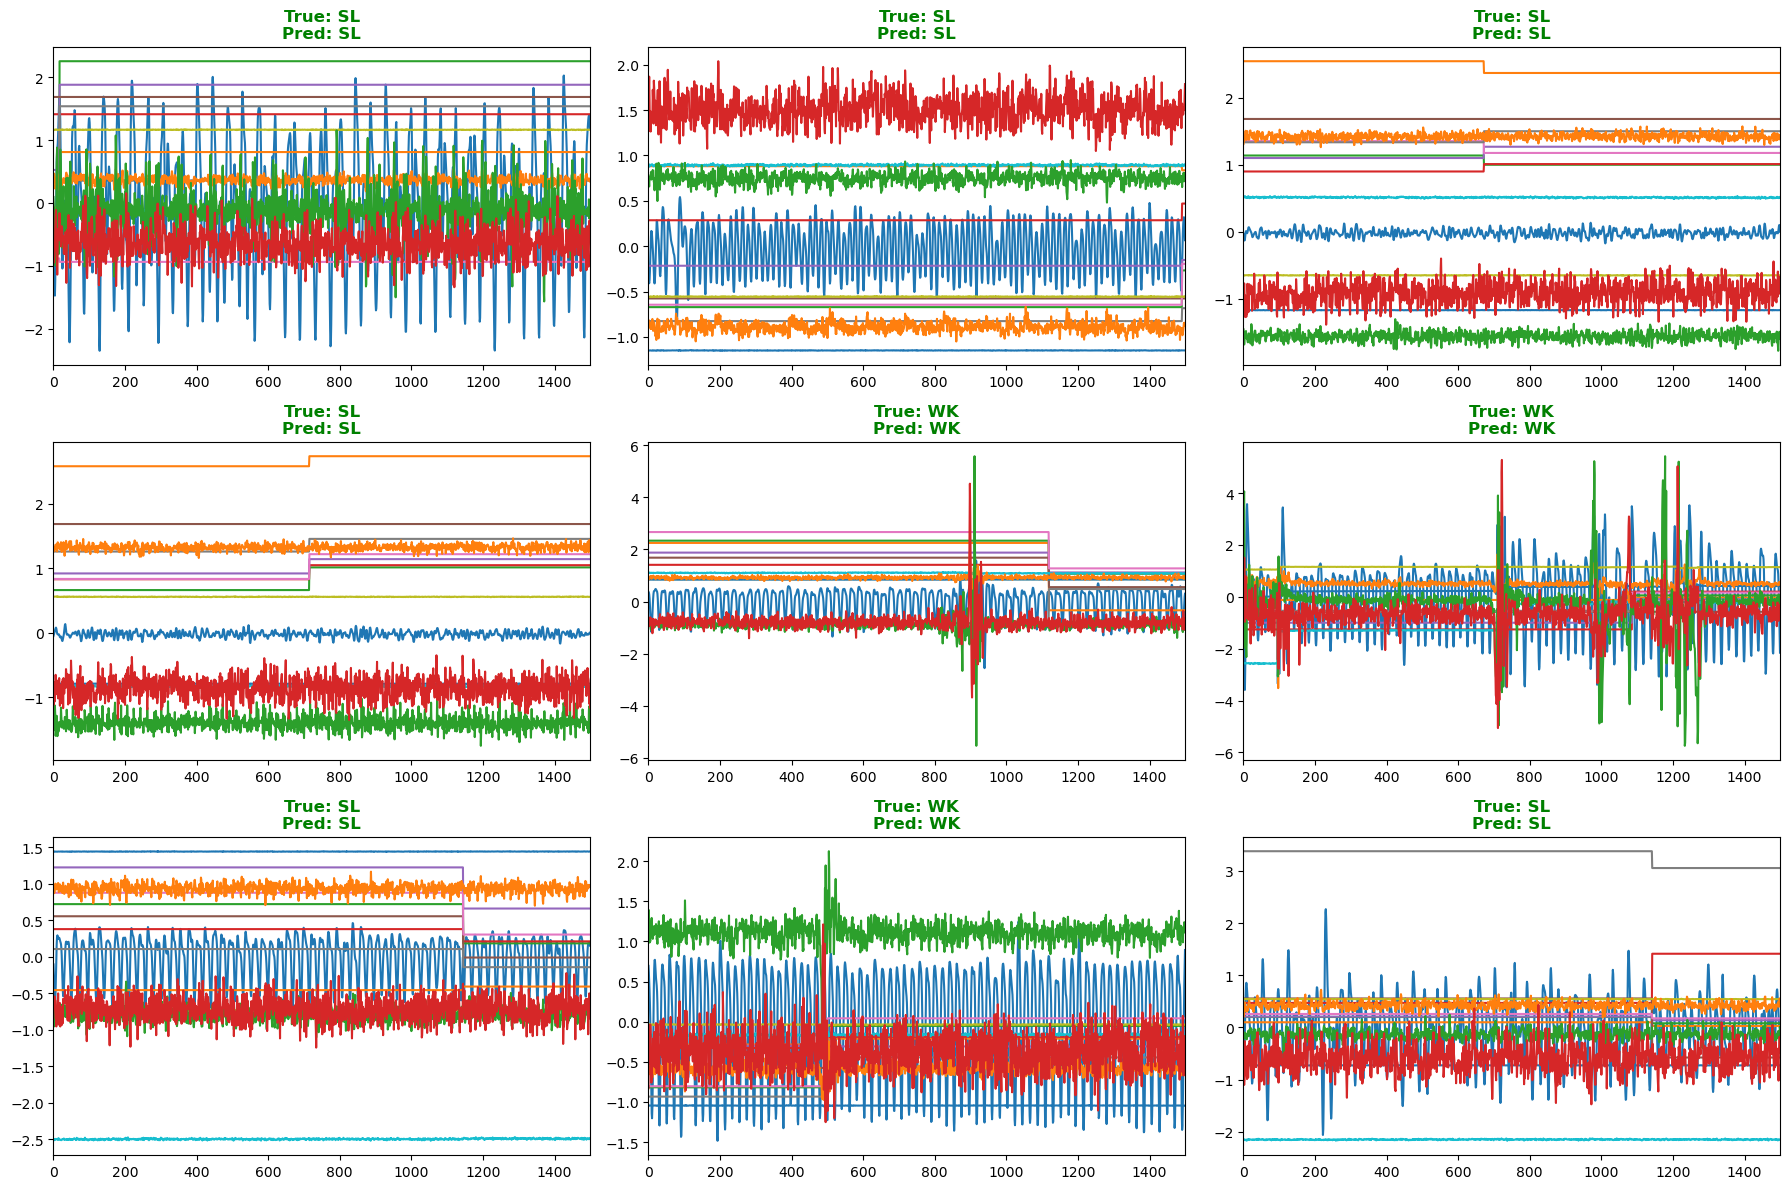

In [57]:
learn.show_results()


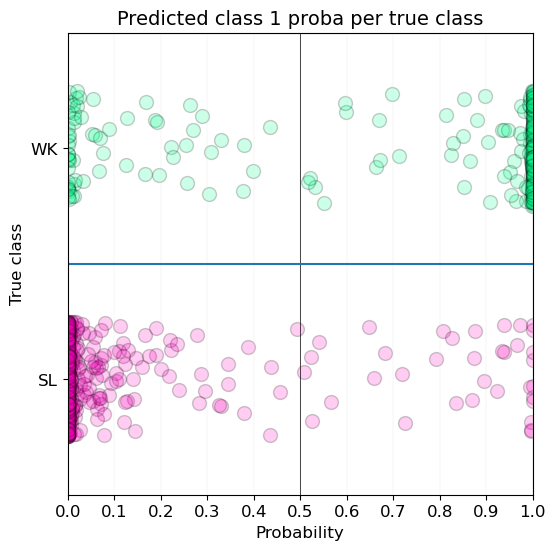

In [58]:
learn.show_probas()


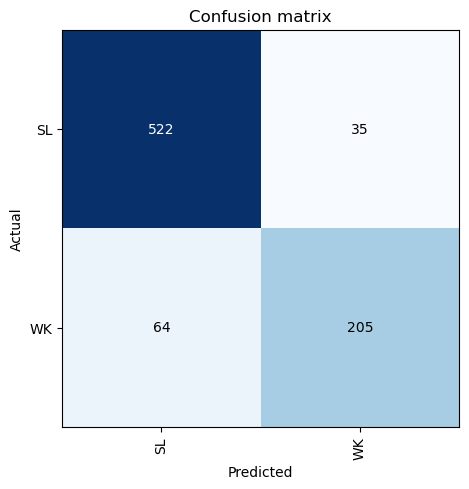

In [59]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [60]:
interp.most_confused(min_val=3)

[('WK', 'SL', 64), ('SL', 'WK', 35)]

In [61]:
print(f'accuracy: {skm.accuracy_score(valid_targets, valid_preds):10.6f}')

accuracy:   0.880145


# inference on unseen data

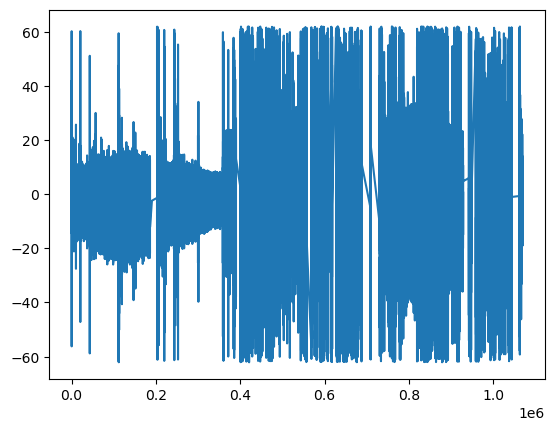

In [62]:
# Read the data
test_data = pd.read_csv('final_test_processed.csv', index_col=0)

test_data = test_data[test_data.sleep_state != -1]

# Binary Classification
test_data["sleep_state"] = np.where(test_data["sleep_state"] == 0, 0, 1)

# fill NaN values
test_data = test_data.fillna(method='bfill', limit=1500).dropna()

# # set column time as datetime index
# df['time'] = pd.to_datetime(df['time'])
# df = df.set_index('time', drop=True)

test_data = test_data[['ledGreen', 'bpm', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'sleep_state']]


# remove extreme values from the signal (outliers)
test_filtered_ppg = remove_extreme_values(test_data['ledGreen'], threshold=3.0)
test_filtered_bpm = remove_extreme_values(test_data['bpm'], threshold=3.0)
test_filtered_rmssd = remove_extreme_values(test_data['rmssd'], threshold=3.0)
test_filtered_pnn20 = remove_extreme_values(test_data['pnn20'], threshold=3.0)
test_filtered_pnn50 = remove_extreme_values(test_data['pnn50'], threshold=3.0)
test_filtered_hr_mad = remove_extreme_values(test_data['hr_mad'], threshold=3.0)
test_filtered_sd1 = remove_extreme_values(test_data['sd1'], threshold=3.0)
test_filtered_sd2 = remove_extreme_values(test_data['sd2'], threshold=3.0)
test_filtered_accelerometerX = remove_extreme_values(test_data['accelerometerX'],
                                                threshold=3.0)
test_filtered_accelerometerY = remove_extreme_values(test_data['accelerometerY'],
                                                threshold=3.0)
test_filtered_accelerometerZ = remove_extreme_values(test_data['accelerometerZ'],
                                                threshold=3.0)
test_filtered_gyroscopeX = remove_extreme_values(test_data['gyroscopeX'], threshold=3.0)
test_filtered_gyroscopeY = remove_extreme_values(test_data['gyroscopeY'], threshold=3.0)
test_filtered_gyroscopeZ = remove_extreme_values(test_data['gyroscopeZ'], threshold=3.0)

test_data['ledGreen'] = test_filtered_ppg
test_data['bpm'] = test_filtered_bpm
test_data['rmssd'] = test_filtered_rmssd
test_data['pnn20'] = test_filtered_pnn20
test_data['pnn50'] = test_filtered_pnn50
test_data['hr_mad'] = test_filtered_hr_mad
test_data['sd1'] = test_filtered_sd1
test_data['sd2'] = test_filtered_sd2
test_data['accelerometerX'] = test_filtered_accelerometerX
test_data['accelerometerY'] = test_filtered_accelerometerY
test_data['accelerometerZ'] = test_filtered_accelerometerZ
test_data['gyroscopeX'] = test_filtered_gyroscopeX
test_data['gyroscopeY'] = test_filtered_gyroscopeY
test_data['gyroscopeZ'] = test_filtered_gyroscopeZ

test_data = test_data.dropna()

plt.plot(test_filtered_ppg)

In [63]:
test_data

,ledGreen,bpm,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,accelerometerX,accelerometerY,accelerometerZ,gyroscopeX,gyroscopeY,gyroscopeZ,sleep_state
47,41.774037,69.942611,163.299316,0.936508,0.746032,40.0,115.466563,61.397187,-1817.50,-901.25,-3665.50,-167.00,-43.75,104.75,0
48,-5.221806,69.942611,163.299316,0.936508,0.746032,40.0,115.466563,61.397187,-1815.75,-892.00,-3662.50,-195.75,-79.75,135.75,0
49,-48.338492,69.942611,163.299316,0.936508,0.746032,40.0,115.466563,61.397187,-1813.50,-897.75,-3665.75,-196.50,-102.00,146.50,0
67,-56.224560,69.942611,163.299316,0.936508,0.746032,40.0,115.466563,61.397187,-1810.75,-900.25,-3671.50,-166.50,-41.25,119.75,0
68,-40.920576,69.942611,163.299316,0.936508,0.746032,40.0,115.466563,61.397187,-1822.00,-890.25,-3663.75,-182.25,-61.50,140.25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069496,-11.443656,79.062958,94.058805,0.823529,0.558824,40.0,66.322062,50.382619,-257.75,676.50,3972.75,-220.25,-57.50,116.50,1
1069497,-13.532598,79.062958,94.058805,0.823529,0.558824,40.0,66.322062,50.382619,-262.50,671.25,3971.00,-217.00,-58.25,134.75,1
1069498,-13.153214,79.062958,94.058805,0.823529,0.558824,40.0,66.322062,50.382619,-258.75,674.50,3972.25,-219.00,-73.00,116.00,1
1069499,-10.268526,79.062958,94.058805,0.823529,0.558824,40.0,66.322062,50.382619,-258.00,679.50,3972.50,-214.00,-62.00,124.00,1


In [64]:
scaler = RobustScaler()
le = LabelEncoder()

X_test = scaler.fit_transform(test_data.drop('sleep_state', axis=1))
y_test = le.fit_transform(test_data['sleep_state'])

# selecting sequences range
X_test = X_test[0:(len(X_test) - len(X_test) % 1500)]
y_test = y_test[0:(len(y_test) - len(y_test) % 1500)]


In [65]:
# reshape the data to tsai format
X_test = X_test.reshape(-1, 1500, 14)
X_test = X_test.transpose(0, 2, 1)
y_test = y_test.reshape(-1, 1500)
y_test = (y_test.sum(axis=1) // 1500).reshape(-1, 1).flatten()

print(X_test.shape, y_test.shape)

pd.DataFrame(X_test[0]).head()

(432, 14, 1500) (432,)


,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,2.030159,-0.456270,-2.737463,-3.154694,-2.345000,-1.623828,-0.994978,-0.440997,0.061905,0.537465,...,0.220249,0.238835,0.242084,0.215960,0.139134,-0.013400,-0.243884,-0.513610,-0.751894,-0.891319
1,-0.018118,-0.018118,-0.018118,-0.018118,-0.018118,-0.018118,-0.018118,-0.018118,-0.018118,-0.018118,...,0.003771,0.003771,0.003771,0.003771,0.003771,0.003771,0.003771,0.003771,0.003771,0.003771
2,1.622644,1.622644,1.622644,1.622644,1.622644,1.622644,1.622644,1.622644,1.622644,1.622644,...,1.965707,1.965707,1.965707,1.965707,1.965707,1.965707,1.965707,1.965707,1.965707,1.965707
3,1.403314,1.403314,1.403314,1.403314,1.403314,1.403314,1.403314,1.403314,1.403314,1.403314,...,1.046392,1.046392,1.046392,1.046392,1.046392,1.046392,1.046392,1.046392,1.046392,1.046392
4,1.695011,1.695011,1.695011,1.695011,1.695011,1.695011,1.695011,1.695011,1.695011,1.695011,...,1.756158,1.756158,1.756158,1.756158,1.756158,1.756158,1.756158,1.756158,1.756158,1.756158


In [67]:
# Labelled test data
test_ds = valid_dl.dataset.add_test(
    X_test)  # In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:14, len:1500, device=cuda:0, dtype=torch.float32),)

In [68]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl,
                                                        with_decoded=True,
                                                        save_preds=None,
                                                        save_targs=None)
test_probas, test_targets, test_preds


(tensor([[2.1027e-01, 7.8973e-01],
         [5.1256e-08, 1.0000e+00],
         [9.9863e-01, 1.3670e-03],
         [9.9993e-01, 7.3047e-05],
         [9.9103e-01, 8.9719e-03],
         [9.2244e-01, 7.7563e-02],
         [9.9990e-01, 1.0307e-04],
         [8.0666e-05, 9.9992e-01],
         [4.5164e-10, 1.0000e+00],
         [9.9886e-01, 1.1386e-03],
         [9.8546e-01, 1.4540e-02],
         [9.9912e-01, 8.7789e-04],
         [9.9886e-01, 1.1364e-03],
         [7.8426e-01, 2.1574e-01],
         [9.0919e-01, 9.0813e-02],
         [8.0262e-02, 9.1974e-01],
         [2.0402e-01, 7.9598e-01],
         [8.4023e-01, 1.5977e-01],
         [7.2599e-01, 2.7401e-01],
         [6.1334e-01, 3.8666e-01],
         [9.7717e-01, 2.2827e-02],
         [8.2945e-01, 1.7055e-01],
         [8.7996e-01, 1.2004e-01],
         [8.8857e-01, 1.1143e-01],
         [7.8508e-01, 2.1492e-01],
         [9.9399e-01, 6.0122e-03],
         [9.8595e-01, 1.4051e-02],
         [9.9170e-01, 8.3039e-03],
         [9.9686e-01

In [69]:
print(f'accuracy: {skm.accuracy_score(y_test, test_preds):10.6f}')

accuracy:   0.601852


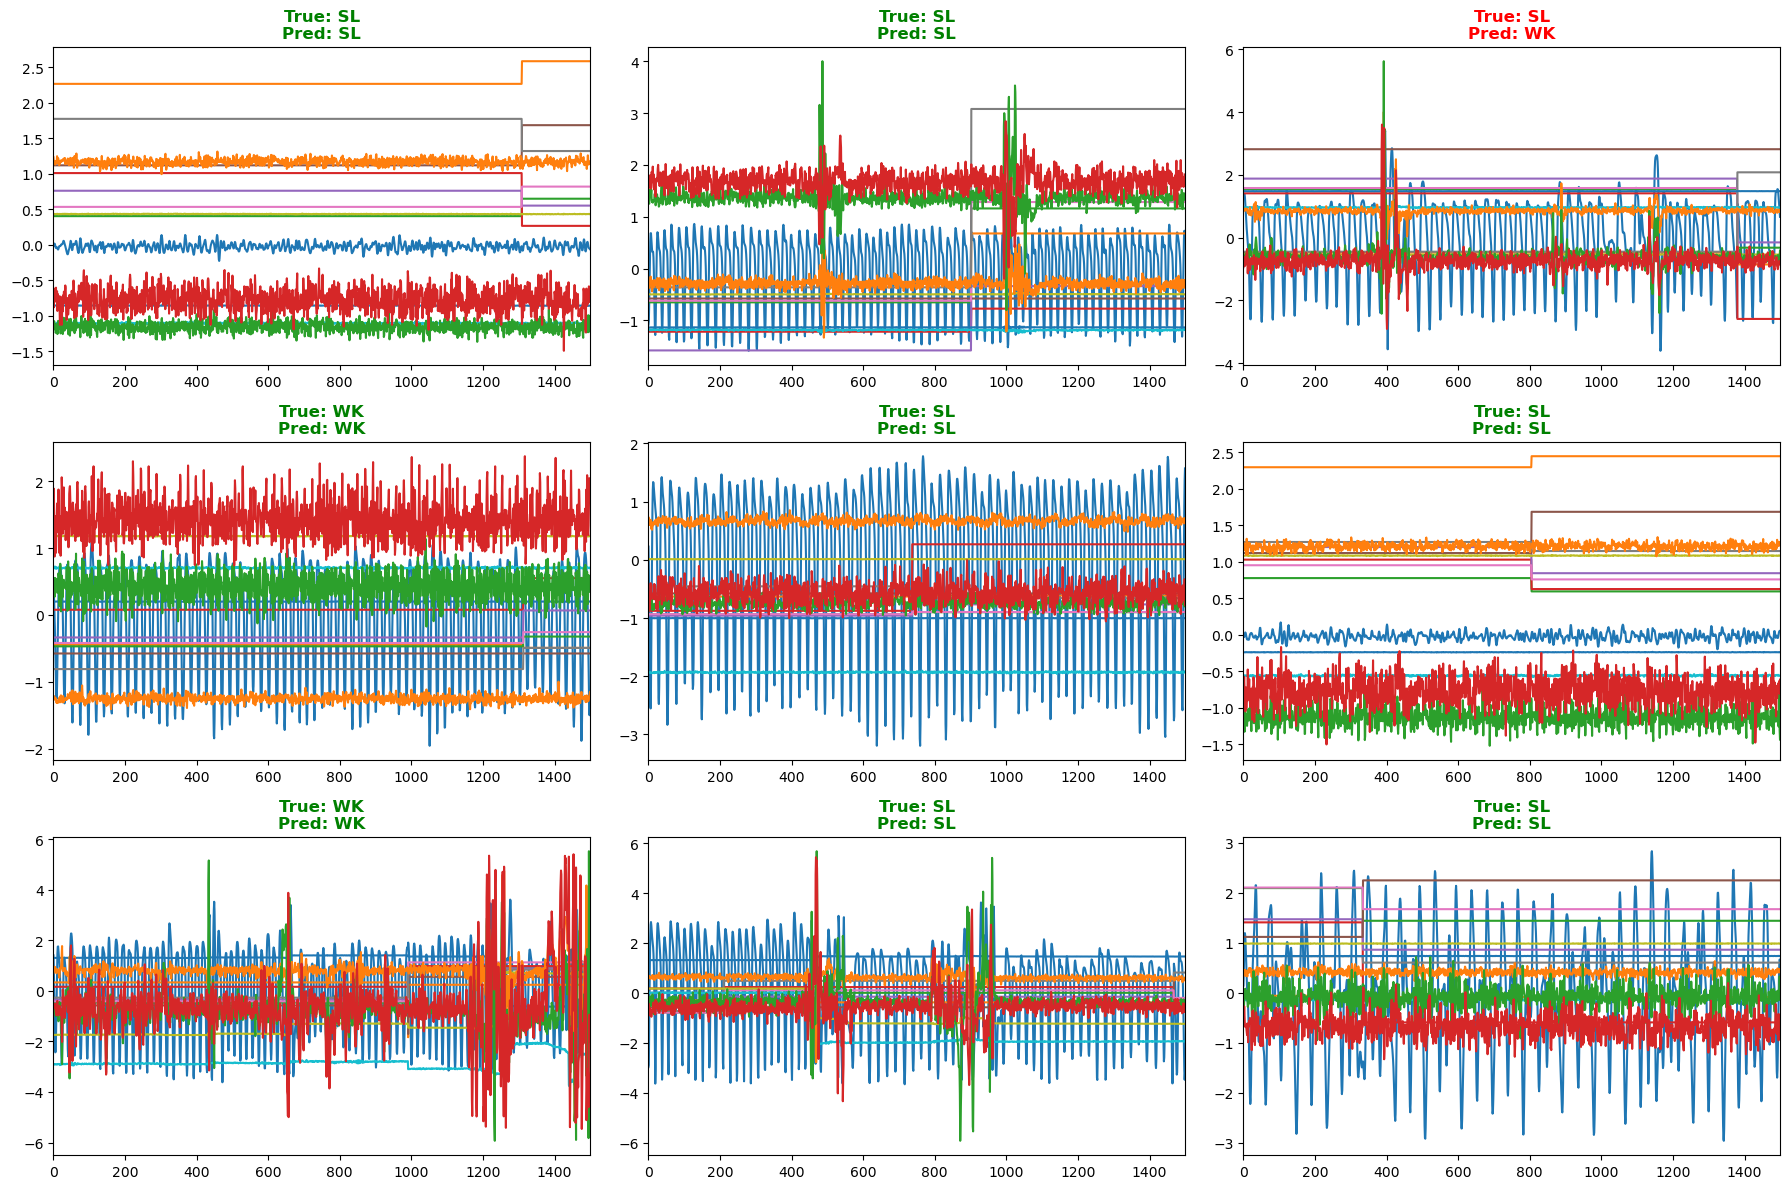

In [70]:
learn.show_results()


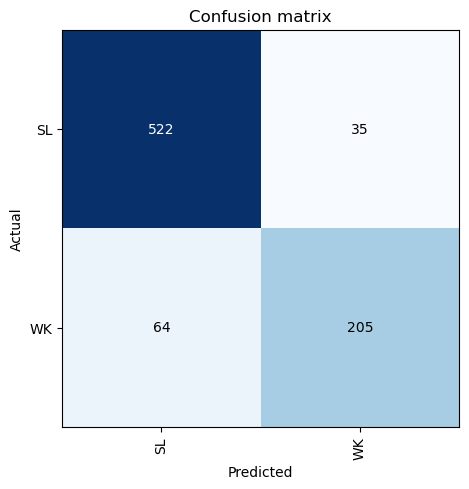

In [71]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### If unlabelled data

In [ ]:
# Unlabelled data
test_ds = dls.dataset.add_test(X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas
